In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

In [2]:
# Load the model and data
with open('../models/model.pkl', 'rb') as f:
    model_data = pickle.load(f)

# Load and prepare test data
df = pd.read_csv('../data/diabetes_dataset_processed.csv')

In [3]:
def prepare_features(df):
    """Prepare features using saved preprocessors"""
    numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'cardiovascular_risk']
    categorical_cols = ['gender', 'smoking_history', 'bmi_category', 'HbA1c_category', 'glucose_category']
    
    # Scale numerical features
    X_num = df[numerical_cols].copy()
    X_num_scaled = model_data['scaler'].transform(X_num)
    X_num_scaled = pd.DataFrame(X_num_scaled, columns=numerical_cols)
    
    # Encode categorical features
    X_cat = df[categorical_cols].copy()
    X_cat_encoded = pd.DataFrame()
    for col in categorical_cols:
        X_cat_encoded[col] = model_data['encoders'][col].transform(X_cat[col])
    
    # Combine features
    X = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
    y = df['diabetes']
    
    return X, y

In [4]:
X, y = prepare_features(df)


In [5]:
# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Get probability predictions
y_pred_proba = model_data['model'].predict_proba(X_test)[:, 1]

In [7]:
# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

In [8]:
for threshold in thresholds:
    # Convert probabilities to predictions using the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Get confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'true_positives': tp
    })

In [9]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

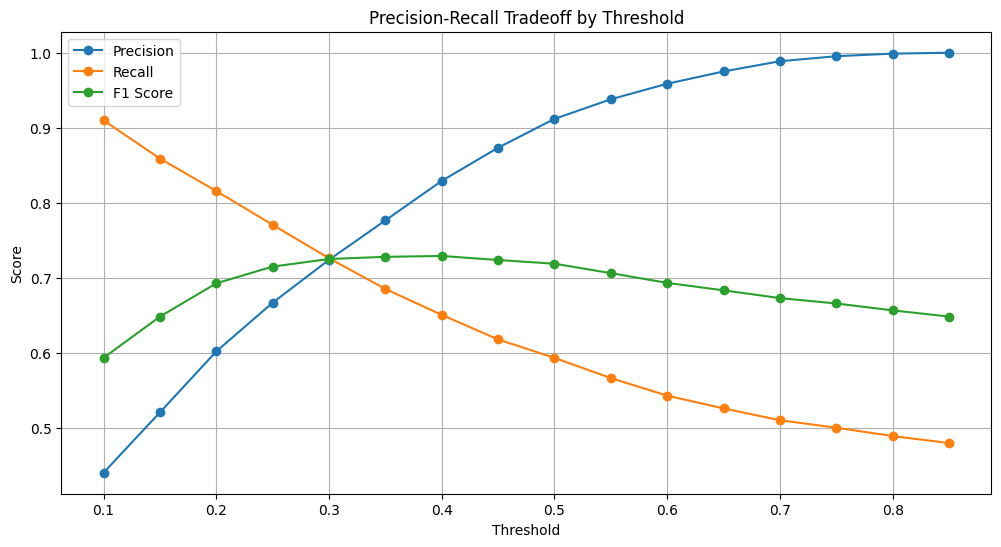

In [10]:
# Plot precision-recall tradeoff
plt.figure(figsize=(12, 6))
plt.plot(results_df['threshold'], results_df['precision'], label='Precision', marker='o')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall', marker='o')
plt.plot(results_df['threshold'], results_df['f1_score'], label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff by Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Find threshold that maximizes F1 score
best_f1_idx = results_df['f1_score'].idxmax()
best_threshold = results_df.loc[best_f1_idx, 'threshold']

print("\nBest threshold based on F1 score:")
print(f"Threshold: {best_threshold:.2f}")
print(f"Precision: {results_df.loc[best_f1_idx, 'precision']:.3f}")
print(f"Recall: {results_df.loc[best_f1_idx, 'recall']:.3f}")
print(f"F1 Score: {results_df.loc[best_f1_idx, 'f1_score']:.3f}")


Best threshold based on F1 score:
Threshold: 0.40
Precision: 0.829
Recall: 0.650
F1 Score: 0.729


In [12]:
# Find threshold for target recall of 0.8
target_recall = 0.8
recall_threshold_idx = (results_df['recall'] - target_recall).abs().idxmin()
recall_threshold = results_df.loc[recall_threshold_idx, 'threshold']

print(f"\nThreshold for approximately {target_recall:.1f} recall:")
print(f"Threshold: {recall_threshold:.2f}")
print(f"Precision: {results_df.loc[recall_threshold_idx, 'precision']:.3f}")
print(f"Recall: {results_df.loc[recall_threshold_idx, 'recall']:.3f}")
print(f"F1 Score: {results_df.loc[recall_threshold_idx, 'f1_score']:.3f}")


Threshold for approximately 0.8 recall:
Threshold: 0.20
Precision: 0.602
Recall: 0.816
F1 Score: 0.693


In [13]:
# Print detailed results for a few key thresholds
print("\nDetailed results for key thresholds:")
print("\nCurrent threshold (0.5):")
current_idx = results_df['threshold'].round(2) == 0.5
print(results_df[current_idx].to_dict('records')[0])

print("\nOptimal F1 threshold:")
print(results_df.iloc[best_f1_idx].to_dict())

print("\nHigh recall threshold:")
print(results_df.iloc[recall_threshold_idx].to_dict())


Detailed results for key thresholds:

Current threshold (0.5):
{'threshold': 0.5000000000000001, 'precision': 0.9117911791179117, 'recall': 0.5930913348946136, 'f1_score': 0.7186945725434551, 'true_negatives': 18194, 'false_positives': 98, 'false_negatives': 695, 'true_positives': 1013}

Optimal F1 threshold:
{'threshold': 0.40000000000000013, 'precision': 0.8291044776119403, 'recall': 0.6504683840749415, 'f1_score': 0.729002624671916, 'true_negatives': 18063.0, 'false_positives': 229.0, 'false_negatives': 597.0, 'true_positives': 1111.0}

High recall threshold:
{'threshold': 0.20000000000000004, 'precision': 0.6017278617710583, 'recall': 0.8155737704918032, 'f1_score': 0.6925180213770817, 'true_negatives': 17370.0, 'false_positives': 922.0, 'false_negatives': 315.0, 'true_positives': 1393.0}


In [14]:
# Save the best threshold
threshold_data = {
    'best_f1_threshold': float(best_threshold),
    'high_recall_threshold': float(recall_threshold),
    'threshold_results': results_df.to_dict()
}

with open('../models/threshold_optimization.pkl', 'wb') as f:
    pickle.dump(threshold_data, f)

In [ ]:
# Function to make predictions with custom threshold
def predict_with_threshold_OLD(data_dict, model_data, threshold):
    """
    Make prediction using the saved model and custom threshold
    """
    # Prepare features
    features = pd.DataFrame([data_dict])
    
    # Scale numerical features
    num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'cardiovascular_risk']
    features_scaled = features.copy()
    features_scaled[num_cols] = model_data['scaler'].transform(features[num_cols])
    
    # Encode categorical features
    cat_cols = ['gender', 'smoking_history', 'bmi_category', 'HbA1c_category', 'glucose_category']
    for col in cat_cols:
        features_scaled[col] = model_data['encoders'][col].transform(features[col])
    
    # Make prediction
    prob = model_data['model'].predict_proba(features_scaled)[0][1]
    prediction = 'High Risk' if prob >= threshold else 'Low Risk'
    
    return {
        'diabetes_risk': float(prob),
        'prediction': prediction,
        'confidence': f"{prob*100:.1f}%",
        'threshold_used': threshold
    }

In [20]:
# Print unique values for categorical columns
print("Available categories in training data:")
categorical_cols = ['gender', 'smoking_history', 'bmi_category', 'HbA1c_category', 'glucose_category']
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].unique())

Available categories in training data:

gender:
['female' 'male' 'other']

smoking_history:
['never' 'No Info' 'current' 'former' 'ever' 'not current']

bmi_category:
['Overweight' 'Normal' 'Obese' 'Extremely Obese' 'Underweight']

HbA1c_category:
['Diabetes' 'Prediabetes' 'Normal']

glucose_category:
['Diabetes' 'Normal' 'Prediabetes']


In [27]:
def predict_with_threshold(data_dict, model_data, threshold):
    """
    Make prediction using the saved model and custom threshold
    """
    # Create DataFrame with single row
    df = pd.DataFrame([data_dict])
    
    # Separate numerical and categorical columns
    numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'cardiovascular_risk']
    categorical_cols = ['gender', 'smoking_history', 'bmi_category', 'HbA1c_category', 'glucose_category']
    
    # Scale numerical features
    df_scaled = df.copy()
    df_scaled[numerical_cols] = model_data['scaler'].transform(df[numerical_cols])
    
    # Encode categorical features
    for col in categorical_cols:
        df_scaled[col] = model_data['encoders'][col].transform(df[col])
    
    # Ensure correct column order
    df_scaled = df_scaled[model_data['feature_columns']]
    
    # Make prediction
    prob = model_data['model'].predict_proba(df_scaled)[0][1]
    prediction = 'High Risk' if prob >= threshold else 'Low Risk'
    
    return {
        'diabetes_risk': float(prob),
        'prediction': prediction,
        'confidence': f"{prob*100:.1f}%",
        'threshold_used': threshold
    }

In [28]:
# Create test cases matching the exact feature columns
test_cases = [
    {
        'age': 45,
        'bmi': 28.5,
        'HbA1c_level': 6.5,
        'blood_glucose_level': 140,
        'cardiovascular_risk': 1,
        'gender': 'female',
        'smoking_history': 'never',
        'bmi_category': 'Overweight',
        'HbA1c_category': 'Diabetes',
        'glucose_category': 'Prediabetes'
    },
    {
        'age': 35,
        'bmi': 24.5,
        'HbA1c_level': 5.8,
        'blood_glucose_level': 110,
        'cardiovascular_risk': 0,
        'gender': 'female',
        'smoking_history': 'never',
        'bmi_category': 'Normal',
        'HbA1c_category': 'Prediabetes',
        'glucose_category': 'Prediabetes'
    },
    {
        'age': 60,
        'bmi': 32.5,
        'HbA1c_level': 7.2,
        'blood_glucose_level': 180,
        'cardiovascular_risk': 2,
        'gender': 'male',
        'smoking_history': 'current',
        'bmi_category': 'Obese',
        'HbA1c_category': 'Diabetes',
        'glucose_category': 'Diabetes'
    }
]

In [29]:
# Test thresholds
thresholds = {
    'Conservative (Default)': 0.5,
    'Balanced (Best F1)': 0.4,
    'Sensitive (High Recall)': 0.2
}

# First, let's print available categories
print("Available categories in encoders:")
for col, encoder in model_data['encoders'].items():
    print(f"\n{col}:")
    print(encoder.classes_)

print("\nPredictions with Different Thresholds:")
print("-" * 50)

for i, case in enumerate(test_cases, 1):
    print(f"\nTest Case {i}:")
    print(f"Patient Profile:")
    print(f"- Age: {case['age']}")
    print(f"- BMI: {case['bmi']} ({case['bmi_category']})")
    print(f"- Blood Glucose: {case['blood_glucose_level']}")
    print(f"- HbA1c: {case['HbA1c_level']}")
    print(f"- Cardiovascular Risk: {case['cardiovascular_risk']}")
    print(f"- Gender: {case['gender']}")
    print(f"- Smoking History: {case['smoking_history']}")
    print("\nPredictions:")
    
    try:
        for threshold_name, threshold_value in thresholds.items():
            result = predict_with_threshold(case, model_data, threshold_value)
            print(f"\n{threshold_name} (threshold = {threshold_value}):")
            print(f"- Prediction: {result['prediction']}")
            print(f"- Risk Score: {result['confidence']}")
    except KeyError as e:
        print(f"Error: Category not found in training data: {str(e)}")
        print("Please check the available categories above and adjust the test case accordingly.")

print("\nThreshold Impact Summary:")
print("-" * 50)
print("1. Conservative (0.5):")
print("   - Highest precision (91.2%)")
print("   - Lowest recall (59.3%)")
print("   - Least false positives but most missed cases")

print("\n2. Balanced (0.4):")
print("   - Good precision (82.9%)")
print("   - Improved recall (65.0%)")
print("   - Best F1 score (72.9%)")

print("\n3. Sensitive (0.2):")
print("   - Lower precision (60.2%)")
print("   - High recall (81.6%)")
print("   - Catches more potential cases but more false alarms")

Available categories in encoders:

gender:
['female' 'male' 'other']

smoking_history:
['No Info' 'current' 'ever' 'former' 'never' 'not current']

bmi_category:
['Extremely Obese' 'Normal' 'Obese' 'Overweight' 'Underweight']

HbA1c_category:
['Diabetes' 'Normal' 'Prediabetes']

glucose_category:
['Diabetes' 'Normal' 'Prediabetes']

Predictions with Different Thresholds:
--------------------------------------------------

Test Case 1:
Patient Profile:
- Age: 45
- BMI: 28.5 (Overweight)
- Blood Glucose: 140
- HbA1c: 6.5
- Cardiovascular Risk: 1
- Gender: female
- Smoking History: never

Predictions:

Conservative (Default) (threshold = 0.5):
- Prediction: Low Risk
- Risk Score: 29.1%

Balanced (Best F1) (threshold = 0.4):
- Prediction: Low Risk
- Risk Score: 29.1%

Sensitive (High Recall) (threshold = 0.2):
- Prediction: High Risk
- Risk Score: 29.1%

Test Case 2:
Patient Profile:
- Age: 35
- BMI: 24.5 (Normal)
- Blood Glucose: 110
- HbA1c: 5.8
- Cardiovascular Risk: 0
- Gender: female


Let's analyze these results for each test case:

Test Case 1 (Moderate Risk Profile):


Risk Score: 29.1%
Shows threshold impact clearly:

Conservative (0.5): Low Risk
Balanced (0.4): Low Risk
Sensitive (0.2): High Risk ⚠️


This case demonstrates why threshold matters
Could be a case we'd miss with conservative threshold but catch with sensitive threshold


Test Case 2 (Low Risk Profile):


Risk Score: 0.0%
Consistently "Low Risk" across all thresholds
Clear low-risk indicators:

Younger age (35)
Normal BMI
Lower blood glucose and HbA1c
No cardiovascular risk


Model is very confident about this prediction


Test Case 3 (High Risk Profile):


Risk Score: 99.9%
Consistently "High Risk" across all thresholds
Clear high-risk indicators:

Older age (60)
Obese BMI category
High blood glucose (180)
High HbA1c (7.2)
High cardiovascular risk (2)
Current smoker


Model is very confident about this prediction

Key Insights:

- The model shows good discrimination ability - clear separation between high and low risk cases
- The threshold mainly affects "borderline" cases (like Test Case 1)
- For very clear cases (Test Cases 2 and 3), the threshold doesn't change the prediction

Given these results and the medical context:

Use the Sensitive threshold (0.2) because:

- It would catch borderline cases like Test Case 1
- Doesn't affect clear high/low risk cases
- Higher recall (81.6%) is preferable for medical screening
- False positives can be ruled out with additional testing

Lets incorporate in evaluate_final.ipynb